**Lectura del conjunto de datos CIFAR-10**

In [ ]:
import tensorflow as tf
from keras.applications.inception_v3 import InceptionV3, preprocess_input
import tensorflow_datasets as tfds
train_data, test_data = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)

**Preproceso de las imágenes**

In [2]:
img_size = (299, 299)
num_classes = 10

def preprocess(image, label):
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32)
    image = preprocess_input(image)
    label = tf.one_hot(label, num_classes)
    return image, label

train_data = train_data.map(preprocess)
test_data = test_data.map(preprocess)

**Leemos el modelo InceptionV3 pre-entrenado con imagenet**

El modelo se lee sin la (última) capa 'softmax' (include_top=False)

In [ ]:
M = InceptionV3(input_shape=img_size + (3,),include_top=False, weights='imagenet')

**Se congelan las capas pre-entrenadas para no modificar estos parámetros durante el fine-tuning**

In [6]:
for layer in M.layers:
    layer.trainable = False

**Se añaden algunas nuevas capas entre ellas la (última) capa 'softmax' ajustada al número de clases de la tarea (10)**

In [7]:
from tensorflow import keras
num_classes=10
x = keras.layers.GlobalAveragePooling2D()(M.output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
output = keras.layers.Dense(num_classes, activation='softmax')(x)

**Se construye el modelo uniendo las capas pre-entrenadas (input) con las nuevas capas (output)**

In [8]:
M = keras.models.Model(inputs=M.input, outputs=output)

**Se compila el modelo definiendo algunos de sus parámetros (optimizador, pérdida y métrica)**

In [9]:
M.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

**Se realiza el fine-tuning (con todo el train y el número de épocas establecido durante la optimización de parámetros en el paso previo)** 

In [10]:
batch_size = 32
epochs = 7
train_dataset = train_data.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_data.batch(batch_size).prefetch(tf.data.AUTOTUNE)
H = M.fit(train_dataset, epochs=epochs, validation_data=test_dataset, verbose=1)

Epoch 1/7
1563/1563 [==============================] - 237s 142ms/step - loss: 0.5816 - accuracy: 0.8057 - val_loss: 0.4466 - val_accuracy: 0.8464
Epoch 2/7
1563/1563 [==============================] - 225s 144ms/step - loss: 0.4656 - accuracy: 0.8426 - val_loss: 0.3953 - val_accuracy: 0.8651
Epoch 3/7
1563/1563 [==============================] - 219s 140ms/step - loss: 0.4342 - accuracy: 0.8529 - val_loss: 0.3839 - val_accuracy: 0.8694
Epoch 4/7
1563/1563 [==============================] - 225s 144ms/step - loss: 0.4113 - accuracy: 0.8594 - val_loss: 0.3804 - val_accuracy: 0.8671
Epoch 5/7
1563/1563 [==============================] - 219s 140ms/step - loss: 0.3950 - accuracy: 0.8642 - val_loss: 0.3849 - val_accuracy: 0.8701
Epoch 6/7
1563/1563 [==============================] - 225s 144ms/step - loss: 0.3779 - accuracy: 0.8714 - val_loss: 0.3707 - val_accuracy: 0.8738
Epoch 7/7
1563/1563 [==============================] - 219s 140ms/step - loss: 0.3687 - accuracy: 0.8722 - val_loss: 0

**Representamos gráficamente la evolución del fine-tuning (loss y accuracy)**

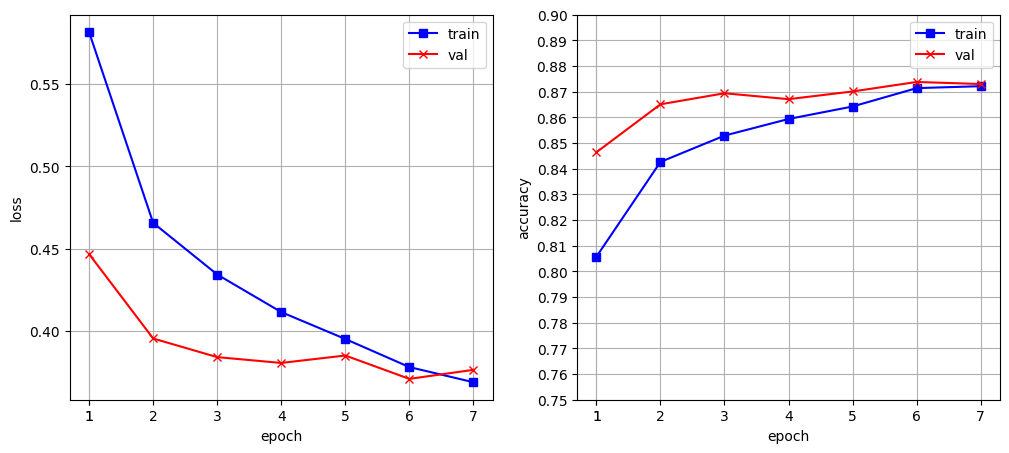

In [11]:
import numpy as np
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
xx = np.arange(1, len(H.history['loss'])+1)
xticks = np.concatenate((np.array([1]), np.arange(1, len(H.history['loss'])+1, 1)))
ax = axes[0]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('loss');
ax.set_xticks(xticks)
ax.plot(xx, H.history['loss'], color='b', marker='s', label='train')
ax.plot(xx, H.history['val_loss'], color='r', marker='x', label='val'); ax.legend()
ax = axes[1]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')
ax.set_xticks(xticks); ax.set_yticks(np.arange(.75, 0.90, .01)); ax.set_ylim([.75, 0.9])
ax.plot(xx, H.history['accuracy'], color='b', marker='s', label='train')
ax.plot(xx, H.history['val_accuracy'], color='r', marker='x', label='val'); ax.legend();

**Guardamos el modelo**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
M.save("/content/drive/My Drive/InceptionV3.keras")